In [41]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split

In [15]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [3]:
# Load data
df = pd.read_csv('data\data.csv', parse_dates=['day'], index_col='day')
df.head()

,Unnamed: 0,item_number,item_name,purchase_price,suggested_retail_price,orders_quantity,sales_quantity,revenue
day,,,,,,,,
2022-02-09,0,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
2022-02-09,1,80317483,ROMA TOMATEN ES I 500G SF,0.92,1.49,0.0,16.0,23.55
2022-02-09,2,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
2022-02-09,3,80101923,SL MANDARINEN BEH.ES I 750G GS,2.05,3.49,0.0,3.0,10.47
2022-02-09,4,80028349,UH ZWIEBELN DE-HE I 1KG GS,0.64,0.99,0.0,13.0,12.84


In [107]:
# Drop unnamed column
data = df.drop('Unnamed: 0', axis=1)

# Drop duplicated rows
data = data.drop_duplicates()
data.head()

# Set the time index right
data = data.iloc[::-1]


# Missing values in revenue indicate either missing data in sales, or maybe no sales at all.

In [108]:
# Obtain Items names and codes
names = data.item_name.unique()
ids = data.item_number.unique()

In [109]:
# Separate the 3 products
p1 = data[data['item_number']==ids[0]]
p2 = data[data['item_number']==ids[1]]
p3 = data[data['item_number']==ids[2]]

In [ ]:
# Split test and train
split = 0.9
p1_train = p1.iloc[:int(len(p1.index) *split),:]
p1_test = p1.iloc[:int(len(p1.index) *(1-split)),:]
p2_train = p2.iloc[:int(len(p2.index) *split),:]
p2_test = p2.iloc[:int(len(p2.index) *(1-split)),:]
p3_train = p3.iloc[:int(len(p3.index) *split),:]
p3_test = p3.iloc[:int(len(p3.index) *(1-split)),:]

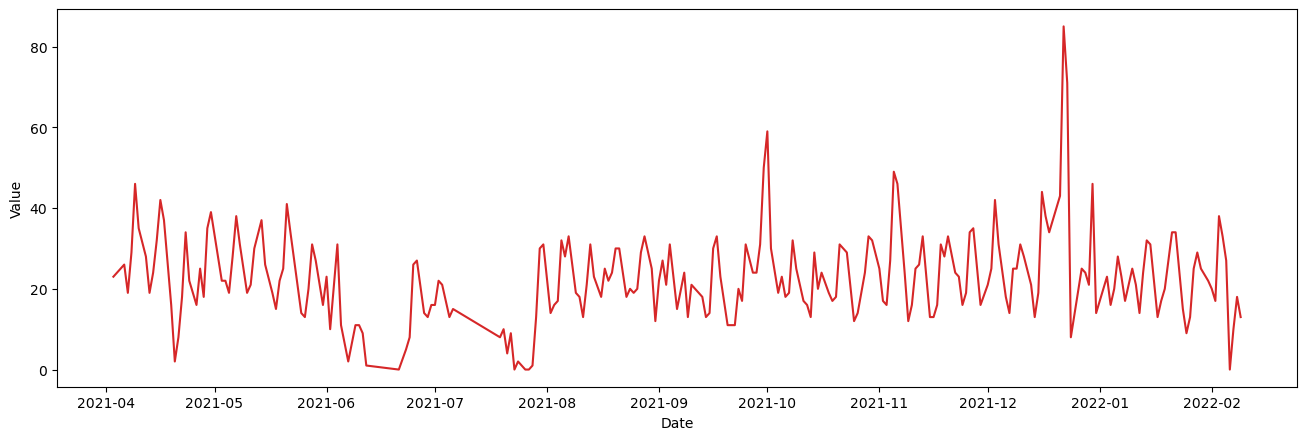

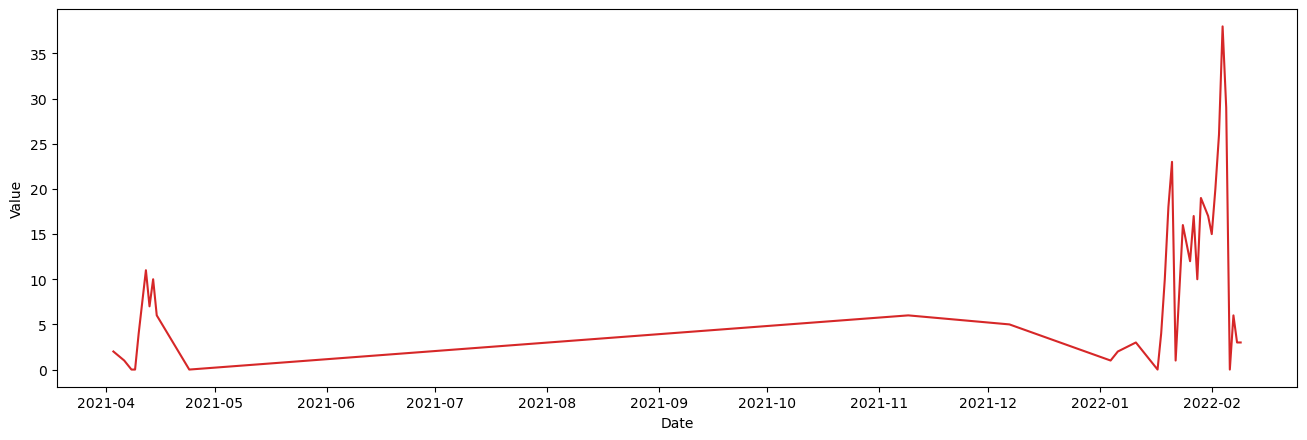

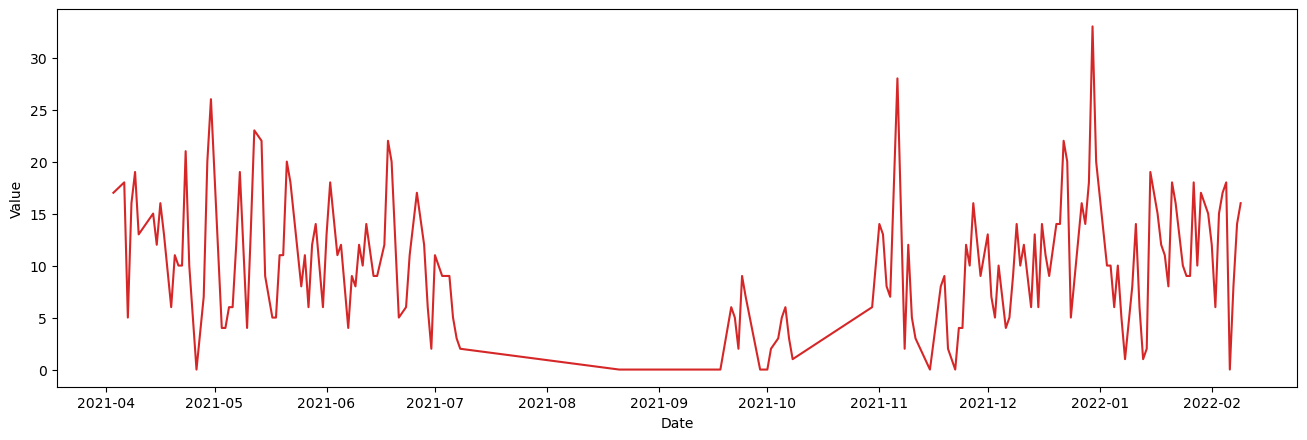

In [110]:
# Look at the sales quantity for each item
plot_df(p1, x=p1.index, y=p1.sales_quantity)
plot_df(p1, x=p2.index, y=p2.sales_quantity)
plot_df(p1, x=p3.index, y=p3.sales_quantity)

Exploring seasonality via the autocorrelation function.
Found weekly seasonality, proceeding with seasonal decomposition.

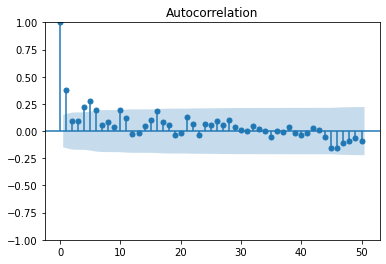

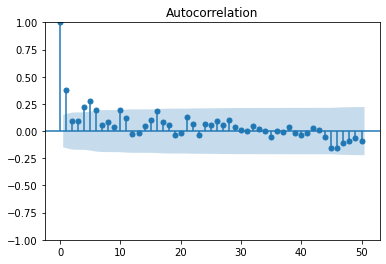

In [111]:
# Look at ACF for seasonality
plot_acf(p3.sales_quantity, lags = 50)

Tried seasonal decomposition below, does not seem like a great candidate
The plots show:
- Trend
- Seasonal
- Residual

Clearly, seasonality has not been properly captured

<AxesSubplot:xlabel='day'>

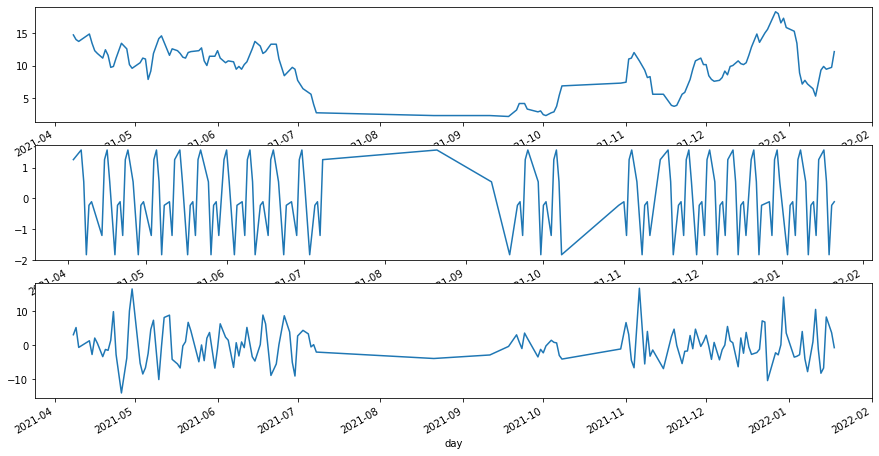

In [113]:
decompose = seasonal_decompose(p3_train['sales_quantity'],model='additive', period=7)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))

decompose.trend.plot(ax=ax1)
decompose.seasonal.plot(ax=ax2)
decompose.resid.plot(ax=ax3)

In [136]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [135]:
model = SARIMAX(p3_train['sales_quantity'], order=(1,1,1), seasonal_order=(0,0,0,7), simple_differencing = False)
model_fit = model.fit()
pred = model_fit.predict(len(p3_test))

C:\Users\ACE-Desktop\anaconda3\envs\freshflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ACE-Desktop\anaconda3\envs\freshflow\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\ACE-Desktop\anaconda3\envs\freshflow\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


### Here is what I spent a long amount of time in:
My initial intention was to use auto_arima. However it looks like I have some installation issues that trigger as soon as I load the library.
I spent quite some time in uninstalls and reinstalls, and eventually gave up, which is why I ended up implementing the SARIMAX model.
Did not have enough time to actually move into MSRE or MAPE or anything like that to test how good the predictions were.

In [68]:
from pmdarima.arima import auto_arima

model = auto_arima(p1_train['sales_quantity'].values.tolist(), trace=True, error_action='ignore', suppress_warnings=True)
model.fit(p1_train)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['sales_quantity'])

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [78]:
import pmdarima as pm


ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject